In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

df_path = '/home/agusitn/Documents/projects/blue-dollar-ml/data/processed/features_advanced.csv'
df = pd.read_csv(df_path, parse_dates=['fecha'], index_col='fecha')

colum_data_leak = [col for col in df.columns if 'rolling' in col]
df[colum_data_leak] = df[colum_data_leak].shift(1)
df.dropna(inplace=True)

df['returns'] = df['valor'].pct_change()
df['target_up'] = (df['returns'] > 0).astype(int)

features = []

for c in df.columns:
    if c not in  ['returns', 'target_up', 'valor']:
        features.append(c)

total_rows = len(df)
train_idx = int(total_rows * 0.70)
val_idx = int(total_rows * 0.85)

x = df[features]
y = df['target_up']

x_train = x.iloc[:train_idx]
y_train = y.iloc[:train_idx]

x_val = x.iloc[train_idx:val_idx]
y_val = y.iloc[train_idx: val_idx]

x_test = x.iloc[val_idx:]
y_test = y.iloc[val_idx:]


""" 
    Debemos normalizar los retornos ya que los datos tienen escalas distintas:
        - El retorno es un número chiquito (ej. 0.01).
        - La volatilidad puede ser otro número diferente.
    La Regresión Logística se confunde si mezclas números grandes con chicos. El StandardScaler pone todo en la misma escala para que el modelo aprenda bien.
"""


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

model = LogisticRegression(random_state=42)
model.fit(x_train_scaled, y_train)

predict = model.predict(x_test_scaled)
accuracy = accuracy_score(y_test, predict)

print("\nResultados del Gran Desafío:")
print(f"Modelo con Features Avanzados: {accuracy:.2%}")
print(f"Baseline a vencer (Como Ayer): 58.68%")

if accuracy > 0.5868:
    print("¡OBJETIVO CUMPLIDO! Tu modelo aprendió patrones reales.")
else:
    print("Seguimos empatados o perdiendo. Necesitamos modelos más complejos.")


Resultados del Gran Desafío:
Modelo con Features Avanzados: 65.15%
Baseline a vencer (Como Ayer): 58.68%
¡OBJETIVO CUMPLIDO! Tu modelo aprendió patrones reales.


Comportamiento con el dataframe: feature_basic.csv

Actualmente el modelo sigue sin superar el baseline de 'como ayer'. Supongo que le faltara mas informacion para poder predecir correctamente el mercado. Mi teoria qes que como a partir del 2023 hubo un cambio presidencial y el dolar fue muy volatil en esas fecha no lo predice correctamente ua que entraria en la ventana del x_test y no del train. Esta hipotesis la voya  confirmar mas adelante cuando realice mas pruebas


Comportamiento con el dataframe: features_advanced.csv

El aprendizaje que logro el modelo de logica regresional con este dataframe que da mas contexto sobre como se mueve el dolar realmente (rsi) .Paso de un 52.4 % a un 65.15% lo cual es un valor significante, incluso superando el baseline de 'como ayer'. Por lo cual usar este dataframe es lo adecuado

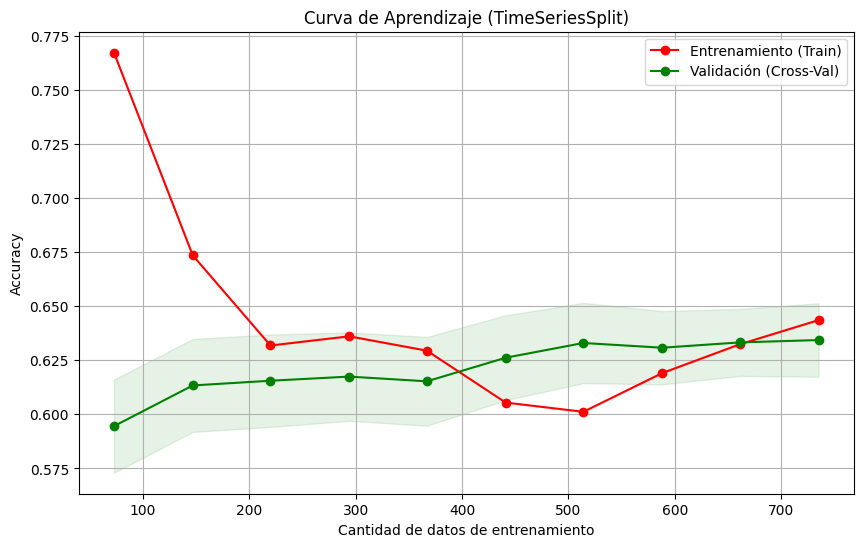

In [4]:
"""Se supone que este grafico es de la curva de aprendizaje, me lo dio chatGPT (permitime dudar de que este bien)"""

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, TimeSeriesSplit

def plot_learning_curve(estimator, x, y):
    # 1. Definimos la estrategia de validación
    # Divide los datos en 5 ventanas progresivas, respetando el orden.
    cv = TimeSeriesSplit(n_splits=5)

    # 2. Calculamos la curva
    # train_sizes: Cuántos datos usa en cada paso (del 10% al 100%)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x, y,
        cv=cv,
        scoring='accuracy', # Usamos accuracy porque es tu métrica principal
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # 3. Calculamos promedios y desvíos (para sombrear el gráfico)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # 4. Graficamos
    plt.figure(figsize=(10, 6))
    plt.title("Curva de Aprendizaje (TimeSeriesSplit)")
    plt.xlabel("Cantidad de datos de entrenamiento")
    plt.ylabel("Accuracy")

    # Línea de Entrenamiento (Rojo)
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Entrenamiento (Train)")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")

    # Línea de Validación (Verde)
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validación (Cross-Val)")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

    plt.legend(loc="best")
    plt.grid()
    plt.show()

#el modelo es el de regresion logistica
plot_learning_curve(model, x_train_scaled, y_train)

Investigando descubri que mi hipotesis era cierta, es decir el gran cambio en el dolar blue en 2023 en impredecible para nuestro modelo ya que es entrenado con datos del 200 al 2018 cuando el dolar estaba tranquilo y no llega a 4 cifras. Por lo cual le resulta imposible a nuestro modelo predecir con un buen porcentaje de acierto.
Se recomiennda usar otro modelo no lineal. Ya que un modelo lineal nos genera el problema mencionado anterioremnete. 

El modelo que voy a utilizar ahora se llama Random Forest Classifier el cual es un modelo no lineal (basado en arboles de desicion)
Piensa como una persona con reglas complejas: "Si el promedio de 10 días es alto, PERO la volatilidad es baja, ENTONCES sube. Pero si la volatilidad es altísima, ENTONCES baja".

In [21]:
"""Creamos el nuevo modelo"""

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd 

df_path = '/home/agusitn/Documents/projects/blue-dollar-ml/data/processed/features_advanced.csv'
df = pd.read_csv(df_path, parse_dates=['fecha'], index_col='fecha')

colum_data_leak = [col for col in df.columns if 'rolling' in col]
df[colum_data_leak] = df[colum_data_leak].shift(1)
df.dropna(inplace=True)

df['returns'] = df['valor'].pct_change()
df['target_up'] = (df['returns'] > 0).astype(int)
features = []

for col in df.columns: 
    if col not in  ['returns', 'target_up', 'valor']:
        features.append(col)

x = df[features]
y = df['target_up']

total_lines = len(df)
# print(total_lines)
data_train = int(total_lines * 0.70)
# print(data_train)
data_validation = int(total_lines * 0.85)

x_train = x.iloc[:data_train]
y_train = y.iloc[:data_train]

x_validation = x.iloc[data_train:data_validation]
y_validation = y.iloc[data_train:data_validation]

x_test = x.iloc[data_validation:]
y_test = y.iloc[data_validation:]

""" Escalo los valores por buena practica nomas ya que el modelo de 
Random forest no me lo pide, porque solo hace preguntas de "si o no" """

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_validation_scaled = scaler.transform(x_validation)
x_test_scaled = scaler.transform(x_test)

model_random_forest = RandomForestClassifier(n_estimators=100, min_samples_split=20, random_state=42)
model_random_forest.fit(x_train_scaled, y_train)

predict = model_random_forest.predict(x_test_scaled)
accuracy = accuracy_score(y_test, predict)

print("\nResultados del Gran Desafío:")
print(f"Modelo con Features Avanzados: {accuracy:.2%}")
print(f"Baseline a vencer (Como Ayer): 58.68%")

if accuracy > 0.5868:
    print("¡OBJETIVO CUMPLIDO! Tu modelo aprendió patrones reales.")
else:
    print("Seguimos empatados o perdiendo. Necesitamos modelos más complejos.")



Resultados del Gran Desafío:
Modelo con Features Avanzados: 62.61%
Baseline a vencer (Como Ayer): 58.68%
¡OBJETIVO CUMPLIDO! Tu modelo aprendió patrones reales.


Iniciando experimento de optimización...
 Con 10 árboles -> Accuracy: 60.70%
 Con 50 árboles -> Accuracy: 61.76%
 Con 100 árboles -> Accuracy: 62.61%
 Con 200 árboles -> Accuracy: 62.29%
 Con 500 árboles -> Accuracy: 62.39%


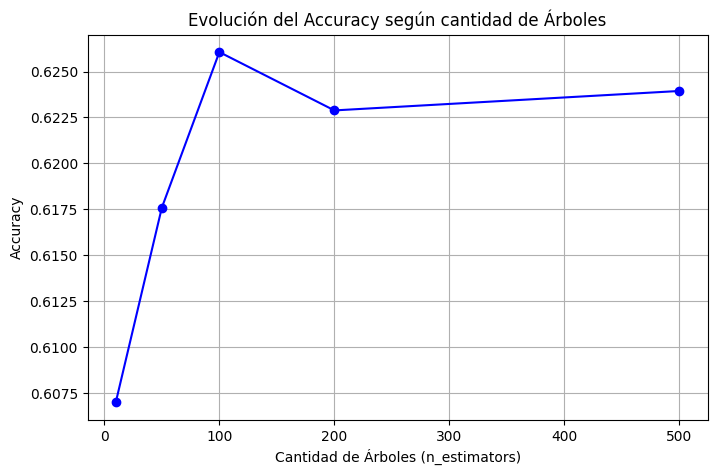

In [8]:
import matplotlib.pyplot as plt

# Lista de cantidades de árboles a probar
n_trees_list = [10, 50, 100, 200, 500]
resultados = []

print("Iniciando experimento de optimización...")

for n in n_trees_list:
    rf = RandomForestClassifier(n_estimators=n, min_samples_split=20, random_state=42, n_jobs=-1)
    
    rf.fit(x_train_scaled, y_train)

    acc = accuracy_score(y_test, rf.predict(x_test_scaled))
    resultados.append(acc)
    
    print(f" Con {n} árboles -> Accuracy: {acc:.2%}")
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees_list, resultados, marker='o', linestyle='-', color='b')
plt.title("Evolución del Accuracy según cantidad de Árboles")
plt.xlabel("Cantidad de Árboles (n_estimators)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

Finalmente el modelo Random forest no resulto util, ya que no mejoramos nada... nuestro modelo no aprendio nuevos patrones asi que se va a tener que realizar una investigacion sobre otros modelos mas utilies para la tarea que quiero realizar...

Investigando llegue a la conclusion de que con el modelo random forest deberia alcanzar para mejorar un poco la curva de aprendizaje. Lo que me esta faltando es darle mas contexto al modelo, como el RSI... asi que vamos a encararlo por ese lado, manteniendo el modelo. 

Ahora que el modelo funciona, no podemos quedarnos solo con el número. Tenemos que preguntarle: "¿Por qué tomaste esas decisiones?".

Esto se llama Feature Importance (Importancia de las Variables). Vamos a hacer un gráfico para ver qué miró el modelo: ¿Fue el RSI? ¿Fue que era fin de mes? ¿O fue la volatilidad?

Se leyeron los datos correctamente
Datos ajustados correctamente
X e y creado correctemete
Datos divididos correctamente (entre el entrenamiento y los test)
Modelo creado y entrenado correctamente


/home/agusitn/Documents/projects/blue-dollar-ml/.venv/lib64/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy Validado: 50.04%


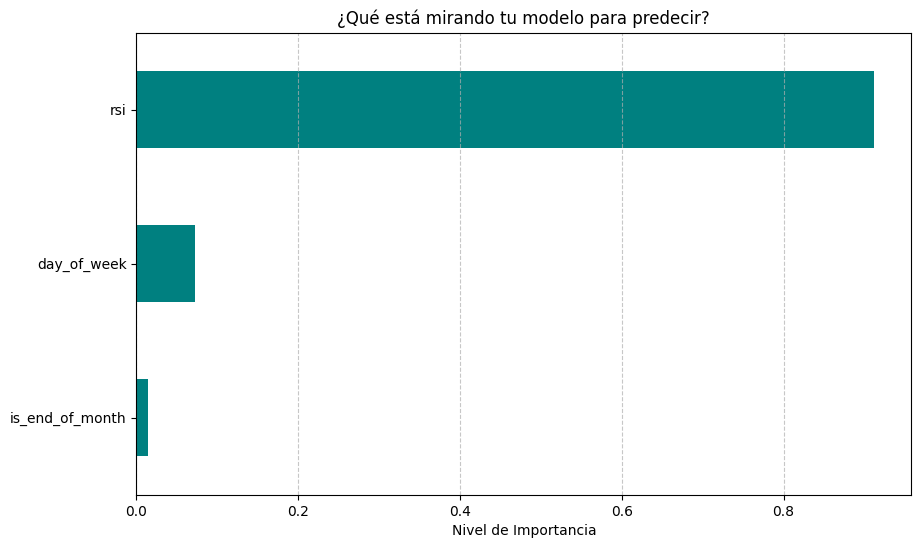

In [ ]:
"""Grafico de feature improtance para el modelo Random Forest"""


import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df = pd.read_csv('/home/agusitn/Documents/projects/blue-dollar-ml/data/processed/features_advanced.csv', parse_dates=['fecha'], index_col='fecha')
print("Se leyeron los datos correctamente")

colum_data_leak = ['rsi']
df[colum_data_leak]  = df[colum_data_leak].shift(1)

df.dropna(inplace=True)

print("Datos ajustados correctamente")

df['returns']  = df['valor'].pct_change()
df['target_up'] = (df['returns'] > 0 ).astype(int)


features = ['rsi', 'day_of_week', 'is_end_of_month']

X = df[features]
y = df['target_up']
print("X e y creado correctemete")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print("Datos divididos correctamente (entre el entrenamiento y los test)")

model = RandomForestClassifier(n_estimators=100, min_samples_split=20, random_state=42)
model.fit(X_train, y_train)
print("Modelo creado y entrenado correctamente")

acc = rf.score(X_test, y_test)
print(f"Accuracy Validado: {acc:.2%}")

importances = pd.Series(rf.feature_importances_, index=features)
importances = importances.sort_values(ascending=True) # Ordenar del peor al mejor

plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='teal')
plt.title("¿Qué está mirando tu modelo para predecir?")
plt.xlabel("Nivel de Importancia")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



Se leyeron los datos correctamente
Datos ajustados correctamente


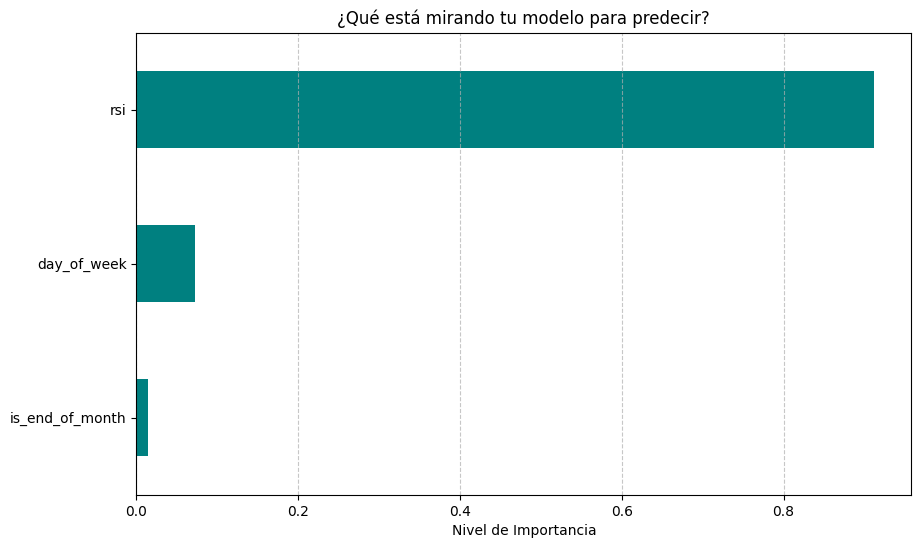


Resultados del Gran Desafío:
Modelo con Features Avanzados: 56.89%
Baseline a vencer (Como Ayer): 58.68%
Seguimos empatados o perdiendo. Necesitamos modelos más complejos.


In [24]:
"""Grafico de feature improtance para el modelo Random Forest"""


import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('/home/agusitn/Documents/projects/blue-dollar-ml/data/processed/features_advanced.csv', parse_dates=['fecha'], index_col='fecha')
print("Se leyeron los datos correctamente")

colum_data_leak = ['rsi']
df[colum_data_leak]  = df[colum_data_leak].shift(1)

df.dropna(inplace=True)

print("Datos ajustados correctamente")

df['returns']  = df['valor'].pct_change()
df['target_up'] = (df['returns'] > 0 ).astype(int)


features = ['rsi', 'day_of_week', 'is_end_of_month']

total_rows = len(df)
train_idx = int(total_rows * 0.70)
val_idx = int(total_rows * 0.85)

x = df[features]
y = df['target_up']

x_train = x.iloc[:train_idx]
y_train = y.iloc[:train_idx]

x_val = x.iloc[train_idx:val_idx]
y_val = y.iloc[train_idx: val_idx]

x_test = x.iloc[val_idx:]
y_test = y.iloc[val_idx:]


""" 
    Debemos normalizar los retornos ya que los datos tienen escalas distintas:
        - El retorno es un número chiquito (ej. 0.01).
        - La volatilidad puede ser otro número diferente.
    La Regresión Logística se confunde si mezclas números grandes con chicos. El StandardScaler pone todo en la misma escala para que el modelo aprenda bien.
"""


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

model = LogisticRegression(random_state=42)
model.fit(x_train_scaled, y_train)

predict = model.predict(x_test_scaled)
accuracy = accuracy_score(y_test, predict)

importances = pd.Series(rf.feature_importances_, index=features)
importances = importances.sort_values(ascending=True) # Ordenar del peor al mejor

plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='teal')
plt.title("¿Qué está mirando tu modelo para predecir?")
plt.xlabel("Nivel de Importancia")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("\nResultados del Gran Desafío:")
print(f"Modelo con Features Avanzados: {accuracy:.2%}")
print(f"Baseline a vencer (Como Ayer): 58.68%")

if accuracy > 0.5868:
    print("¡OBJETIVO CUMPLIDO! Tu modelo aprendió patrones reales.")
else:
    print("Seguimos empatados o perdiendo. Necesitamos modelos más complejos.")